In [1]:
import pandas
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import tensorflow as tf
import zipfile
import os
import PIL
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import random
from stardist.models import StarDist2D
#from keras_unet_collection import models
import keras
import skimage
from sklearn.cluster import KMeans
import scipy
from PIL import Image
import statistics
from skimage.filters import threshold_multiotsu
from numba import jit, cuda
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling2D
from keras import layers
from tensorflow.keras.applications import VGG16
import dill
import stardist
import sklearn
import wget
from skimage.filters import threshold_multiotsu
from tensorflow.keras.utils import to_categorical

2025-09-17 13:37:56.551991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758112676.590326   40427 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758112676.602184   40427 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758112676.632180   40427 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758112676.632219   40427 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758112676.632227   40427 computation_placer.cc:177] computation placer alr

In [2]:
PIL.Image.MAX_IMAGE_PIXELS = 1000000000

In [3]:
api = KaggleApi()
api.authenticate()

In [4]:
train_data = pandas.read_csv("/scratch/c.c23115040/train.csv")
train_data_radboud = train_data[train_data['data_provider'] == 'radboud']
train_data_radboud = train_data_radboud[train_data_radboud['gleason_score'] != 'negative']
index_radboud = np.array(train_data_radboud.index)

In [4]:
np.random.shuffle(index_radboud)

In [6]:
index_radboud

array([ 7685,  5669,  1184, ..., 10302,  8350,  3629])

In [7]:
index_radboud.shape

(4193,)

In [ ]:
#url = 'https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/18647/1126921/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1742666743&Signature=LHgz6Heg08NubYod%2BS7p1ZjP6wcJ%2FwWHIZ%2BQ1Mc7%2BzlIkG1lWl%2BRsb8nfbnis3kWql51Fp7MkyMxLk%2Ba%2BBJYP2CcSO8xhwaQpMiy6nOEh1gl9H1S7PXi5TznZNLcv2YiXWA2kOAaoYZ2JvrHFI3UaODzWFB4oqoT3HUtpUPSEA2vYsc9lkEoI3Wms1AdLcT3JGIFAUL3jTpVi01BDzMbiPDWZVhyosKQeWYM1OCJuDxXGqCEaN6Iw4IebUSwKZbH%2BxlcbgwwDf7xIYxeM3CaowQyRqgija0tUNXtnQUjko0y%2F8Ovnw2FxYCLZxt%2FT3uVu6zF3CoZ6Ve%2BIRwUCrL9fA%3D%3D&response-content-disposition=attachment%3B+filename%3Dprostate-cancer-grade-assessment.zip'
#wget.download(url, '/scratch/c.c23115040/PANDA_Download/prostate-cancer-grade-assessment.zip')
#file = zipfile.ZipFile('/scratch/c.c23115040/PANDA_Download/prostate-cancer-grade-assessment.zip', 'r')
#file.extractall("/scratch/c.c23115040/PANDA_Download/")

In [ ]:
#for i in index_radboud[253:300]:
#    try:
#        api.competition_download_file('prostate-cancer-grade-assessment','train_images/' + train_data.loc[i,"image_id"] + '.tiff', "/scratch/c.c23115040/PANDA/")
#    except:
#        continue
#    time.sleep(30)    
#    try:
#        api.competition_download_file('prostate-cancer-grade-assessment','train_label_masks/' + train_data.loc[i,"image_id"] + '_mask.tiff', "/scratch/c.c23115040/PANDA/")
#    except:
#        continue
#    time.sleep(30)

In [11]:
#for i in os.listdir("/scratch/c.c23115040/PANDA/"):
#    if i.endswith('.zip'):
#        zipfile.ZipFile("/scratch/c.c23115040/PANDA/" + i, 'r').extractall("/scratch/c.c23115040/PANDA/")
#        os.unlink("/scratch/c.c23115040/PANDA/" + i)

In [8]:
def scaled(x):
    sc = (x - np.mean(x))/np.std(x)
    return sc

In [9]:
path2 = "/scratch/c.c23115040/PANDA/train_images/" + train_data.loc[155,"image_id"] + '.tiff'
image_loaded = cv2.imread(path2, 1)
image_loaded = cv2.cvtColor(image_loaded, cv2.COLOR_BGR2RGB)

In [10]:
im = image_loaded[3750:4250, 1000:1500, :].copy()
labels = skimage.morphology.binary_erosion(cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) < threshold_multiotsu(image=cv2.cvtColor(im, cv2.COLOR_RGB2GRAY), classes=3, nbins=255)[0])
im[labels == 0,:] = 0
draq5 = 4095*skimage.filters.gaussian(skimage.morphology.dilation(skimage.util.random_noise(np.abs(-cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)), var = 0.0001)), sigma=0.5, preserve_range=True)
#im2 = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
#im3 = skimage.util.random_noise(im2, var = 0.0001)
#im4 = skimage.morphology.dilation(im3)
#im5 = skimage.filters.gaussian(im4, sigma=0.5, preserve_range=True)

In [11]:
im2 = image_loaded[3750:4250, 1000:1500, :].copy()
im2[labels == 1,:] = 0
#im2[labels > 0,0] = 255
#im2[labels > 0,1] = 255
#im2[labels > 0,2] = 255
eosin = 4095*skimage.filters.gaussian(skimage.morphology.dilation(skimage.util.random_noise(np.abs(-cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY)), var = 0.0001)), sigma=0.5, preserve_range=True)
#im3 = cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY)
#im4 = np.abs(-im3)
#im5 = skimage.util.random_noise(im4, var = 0.0001)
#im6 = skimage.morphology.dilation(im5)
#im7 = skimage.filters.gaussian(im6, sigma=0.5, preserve_range=True)

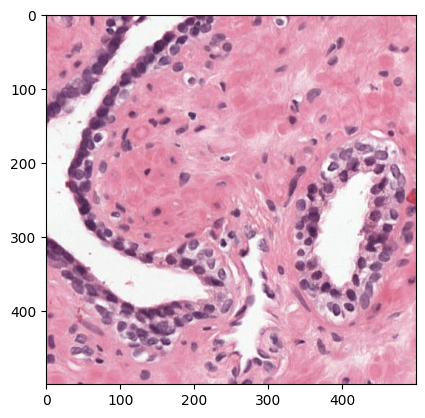

In [13]:
plt.imshow(image_loaded[3750:4250, 1000:1500, :])

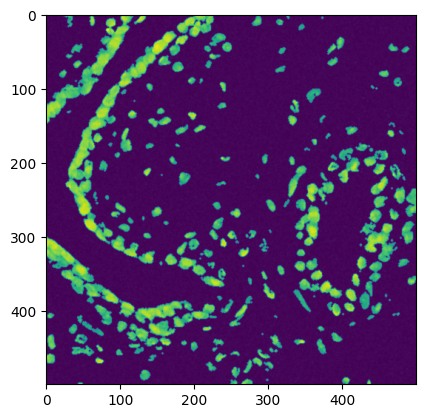

In [14]:
plt.imshow(draq5)

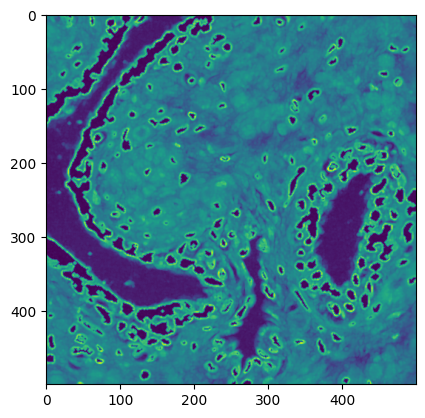

In [15]:
plt.imshow(eosin)

In [ ]:
DRAQ5_input = []
Eosin_input = []
masks_segm = []
classif = []
batch = []
m = 250
r = 0
l = 50
cut = 512
cut_sz = int(cut/2)

for i in index_radboud[0:m]:
    path = "/scratch/c.c23115040/PANDA/train_label_masks/" + train_data.loc[i,"image_id"] + '_mask.tiff'
    image_mask = cv2.imread(path, -1)
    try:
        image_mask = image_mask[:,:,2]
    except:
        continue
    path2 = "/scratch/c.c23115040/PANDA/train_images/" + train_data.loc[i,"image_id"] + '.tiff'
    image_loaded = cv2.imread(path2, 1)
    try:
        image_loaded = cv2.cvtColor(image_loaded, cv2.COLOR_BGR2RGB)
    except:
        continue
    normal = sum(sum(image_mask == 2))
    gleason3 = sum(sum(image_mask == 3))
    gleason4 = sum(sum(image_mask == 4))
    gleason5 = sum(sum(image_mask == 5))
    total = normal + gleason3 + gleason4 + gleason5
    scores = np.asarray((normal/total, gleason3/total, gleason4/total, gleason5/total))
    scores = scores > 0.05
    additions = np.ndarray.tolist(np.asarray(np.where(scores)) + 2)[0]
    for q in additions:
        tissue = image_mask == q
        indices = np.argwhere(tissue)
        for w in range(l):
            x = tissue.shape[0]
            y = tissue.shape[1]
            while x+cut_sz>tissue.shape[0]-1 or x-cut_sz<0 or y+cut_sz>tissue.shape[1]-1 or y-cut_sz<0:
                ind = random.randrange(indices.shape[0])
                x = indices[ind, 0]
                y = indices[ind, 1]
            image_cut = image_mask[x-cut_sz:x+cut_sz, y-cut_sz:y+cut_sz]  
            if sum(sum(image_mask[x-cut_sz:x+cut_sz, y-cut_sz:y+cut_sz] == q))/sum(sum(image_mask[x-cut_sz:x+cut_sz, y-cut_sz:y+cut_sz] > 1)) > 0.75 and sum(sum(image_mask[x-cut_sz:x+cut_sz, y-cut_sz:y+cut_sz] > 1))/(512*512) > 0.15:
                X = cv2.resize(image_loaded[x-cut_sz:x+cut_sz, y-cut_sz:y+cut_sz,:], (256,256), fx=0, fy=0, interpolation = cv2.INTER_NEAREST)
                im = X.copy()
                labels = skimage.morphology.binary_erosion(cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) < threshold_multiotsu(image=cv2.cvtColor(im, cv2.COLOR_RGB2GRAY), classes=3, nbins=255)[0])
                im[labels == 0,:] = 0
                draq5 = 4095*skimage.filters.gaussian(skimage.morphology.dilation(skimage.util.random_noise(np.abs(-cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)), var = 0.0001)), sigma=0.5, preserve_range=True)
                DRAQ5_input.append(scaled(draq5))
                im2 = X.copy()
                im2[labels == 1,:] = 0
                eosin = 4095*skimage.filters.gaussian(skimage.morphology.dilation(skimage.util.random_noise(np.abs(-cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY)), var = 0.0001)), sigma=0.5, preserve_range=True)
                Eosin_input.append(scaled(eosin))
                masks_segm.append(image_cut)
                classif.append(q-2)
                batch.append(r)
    print(r)
    r += 1

In [17]:
with open("/scratch/c.c23115040/DRAQ5_input", "wb") as dill_file: 
    dill.dump(DRAQ5_input, dill_file)
with open("/scratch/c.c23115040/Eosin_input", "wb") as dill_file: 
    dill.dump(Eosin_input, dill_file)
with open("/scratch/c.c23115040/masks_segm", "wb") as dill_file: 
    dill.dump(masks_segm, dill_file)
with open("/scratch/c.c23115040/classif", "wb") as dill_file: 
    dill.dump(classif, dill_file)   
with open("/scratch/c.c23115040/batch", "wb") as dill_file: 
    dill.dump(batch, dill_file)          

In [5]:
with open("/scratch/c.c23115040/DRAQ5_input", "rb") as dill_file:
    DRAQ5_input = dill.load(dill_file)
with open("/scratch/c.c23115040/Eosin_input", "rb") as dill_file:
    Eosin_input = dill.load(dill_file)
with open("/scratch/c.c23115040/masks_segm", "rb") as dill_file:
    masks_segm = dill.load(dill_file)
with open("/scratch/c.c23115040/classif", "rb") as dill_file:
    classif = dill.load(dill_file)
with open("/scratch/c.c23115040/batch", "rb") as dill_file:
    batch = dill.load(dill_file)

In [6]:
len(DRAQ5_input)

18227

In [7]:
classif = np.array(classif)

In [8]:
batch = np.array(batch)

In [9]:
healthy = np.where(classif == 0)[0]
gleason3 = np.where(classif == 1)[0]
gleason4 = np.where(classif == 2)[0]
gleason5 = np.where(classif == 3)[0]
gleason_disease = np.concatenate((gleason4, gleason5))

In [10]:
batch_h = batch[classif == 0]
batch_3 = batch[classif == 1]
batch_4 = batch[classif == 2]
batch_5 = batch[classif == 3]
batch_d = np.concatenate((batch_4, batch_5))

In [11]:
batch

array([  0,   0,   0, ..., 241, 241, 241])

In [12]:
numb = list(range(241))
np.random.shuffle(numb)

In [13]:
list1 = numb[0:193]
list2 = numb[193:241]

In [14]:
classif2 = np.concatenate((np.full((gleason3.shape[0], 1), 0), np.full((gleason_disease.shape[0], 1), 1)))

In [15]:
data = np.concatenate((gleason3, gleason_disease))

In [16]:
batch2 = np.concatenate((batch_3, batch_d))

In [17]:
data = data[:, np.newaxis]

In [18]:
data = np.concatenate((data, classif2, batch2[:, np.newaxis]), axis = 1)
np.random.shuffle(data)

In [19]:
classif3 = data[:, 1]
batch3 = data[:, 2]

In [20]:
splitting = []
for i in range(batch3.shape[0]):
    splitting.append(batch3[i] in list2)
splitting = np.asarray(splitting)
    
data_train = data[splitting == 0, 0]
classif_train = classif3[splitting == 0].astype(np.uint8)
data_test = data[splitting == 1, 0]
classif_test = classif3[splitting == 1].astype(np.uint8)

DRAQ5_input = np.array(DRAQ5_input).astype(np.float16)
Eosin_input = np.array(Eosin_input).astype(np.float16)
    
DRAQ5_input_train = DRAQ5_input[data_train, :, :].astype(np.float16)
DRAQ5_input_test = DRAQ5_input[data_test, :, :].astype(np.float16)
Eosin_input_train = Eosin_input[data_train, :, :].astype(np.float16)
Eosin_input_test = Eosin_input[data_test, :, :].astype(np.float16)

input_train = np.concatenate((DRAQ5_input_train[:,:,:,np.newaxis], Eosin_input_train[:,:,:,np.newaxis]), axis = 3).astype(np.float16)
input_test = np.concatenate((DRAQ5_input_test[:,:,:,np.newaxis], Eosin_input_test[:,:,:,np.newaxis]), axis = 3).astype(np.float16)    

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath="/home/c.c23115040/checkpoint.model.keras", monitor='val_loss', mode='min', save_best_only=True)
    
model = Sequential()
model.add(layers.Conv2D(16, (3,3), padding='same', activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(), input_shape=(256, 256, 2)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Conv2D(32, (3,3), padding='same', activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform()))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Conv2D(64, (3,3), padding='same', activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform()))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Conv2D(32, (3,3), padding='same', activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform()))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Conv2D(16, (3,3), padding='same', activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform()))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(800, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform()))
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(400, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform()))
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(100, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform()))
model.add(layers.Dense(50, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform()))
model.add(layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform()))
      
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
history = model.fit(input_train, classif_train, validation_data=(input_test, classif_test), epochs=20, callbacks=[model_checkpoint_callback])

model = keras.models.load_model("/home/c.c23115040/checkpoint.model.keras")

base_conv.py (113): Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2025-07-09 17:28:00.110679: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 286s 779ms/step - accuracy: 0.5980 - loss: 0.7389 - val_accuracy: 0.6192 - val_loss: 0.6642
Epoch 2/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 267s 748ms/step - accuracy: 0.6403 - loss: 0.6451 - val_accuracy: 0.6241 - val_loss: 0.6367
Epoch 3/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 260s 728ms/step - accuracy: 0.6550 - loss: 0.6160 - val_accuracy: 0.6682 - val_loss: 0.5732
Epoch 4/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 259s 725ms/step - accuracy: 0.6908 - loss: 0.5642 - val_accuracy: 0.7085 - val_loss: 0.5311
Epoch 5/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 256s 718ms/step - accuracy: 0.7347 - loss: 0.5257 - val_accuracy: 0.7127 - val_loss: 0.5304
Epoch 6/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 259s 725ms/step - accuracy: 0.7571 - loss: 0.4921 - val_accuracy: 0.7832 - val_loss: 0.4561
Epoch 7/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 256s 719ms/step - accuracy: 0.7651 - loss: 0.4629 - val_accuracy: 0.7941 - val_loss: 0.4410
Epoch 8/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 258s 722ms/step - accuracy: 0.7871 -

In [21]:
sklearn.metrics.accuracy_score(classif_test, model.predict(input_test) > 0.5)

83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step


0.7997737556561086

In [22]:
sklearn.metrics.cohen_kappa_score(classif_test, model.predict(input_test) > 0.5)

83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step


0.5616094976950605

In [23]:
sklearn.metrics.confusion_matrix(classif_test, model.predict(input_test) > 0.5)

83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step


array([[ 662,  347],
       [ 184, 1459]])

In [24]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(classif_test, model.predict(input_test))
auc = sklearn.metrics.auc(fpr, tpr)

83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step


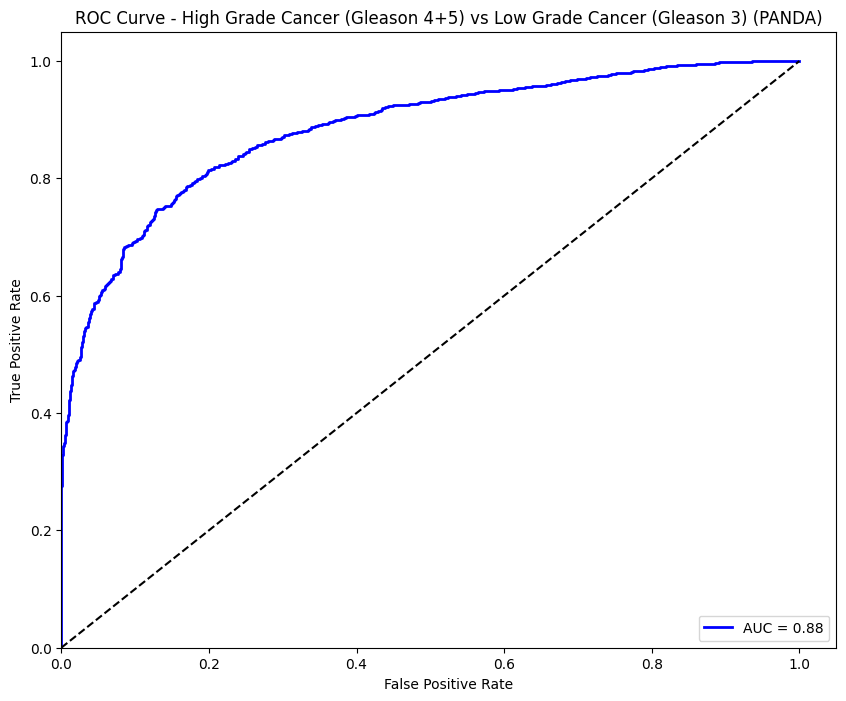

In [25]:
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, color='blue', lw=2, label='AUC = %0.2f' % auc)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - High Grade Cancer (Gleason 4+5) vs Low Grade Cancer (Gleason 3) (PANDA)')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc="lower right")

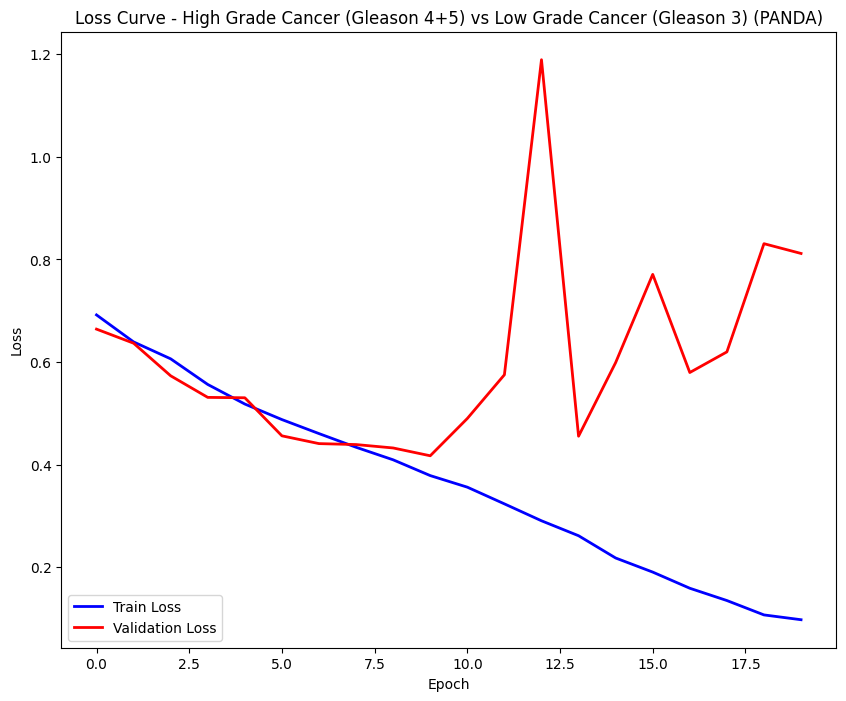

In [26]:
plt.figure(figsize=(10,8))
plt.plot(range(20), history.history['loss'], color='blue', lw=2, label = 'Train Loss')
plt.plot(range(20), history.history['val_loss'], color='red', lw=2,  label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve - High Grade Cancer (Gleason 4+5) vs Low Grade Cancer (Gleason 3) (PANDA)')
plt.legend(loc="lower left")

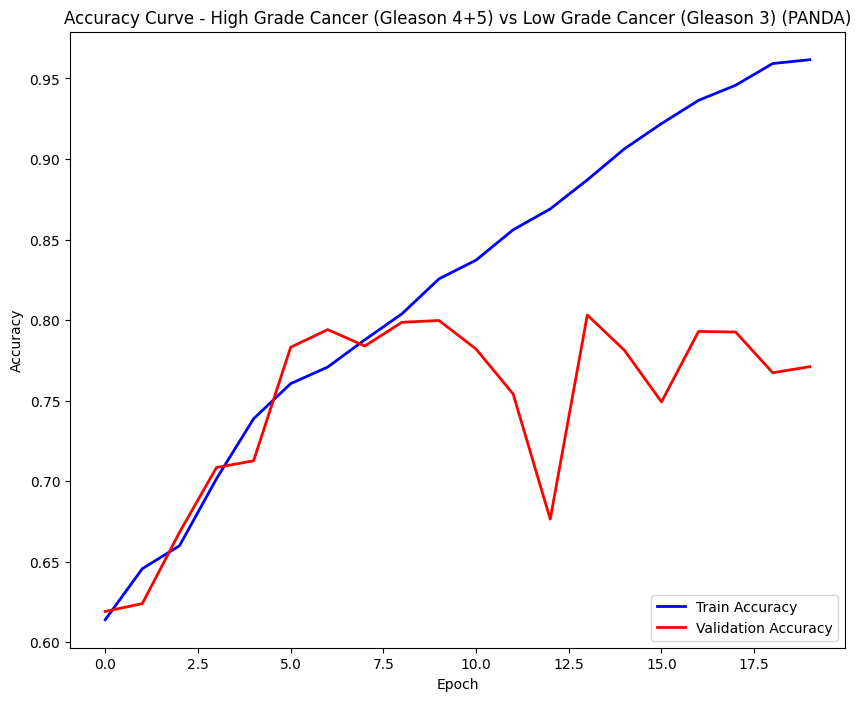

In [28]:
plt.figure(figsize=(10,8))
plt.plot(range(20), history.history['accuracy'], color='blue', lw=2, label = 'Train Accuracy')
plt.plot(range(20), history.history['val_accuracy'], color='red', lw=2,  label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve - High Grade Cancer (Gleason 4+5) vs Low Grade Cancer (Gleason 3) (PANDA)')
plt.legend(loc="lower right")

In [29]:
with open("/scratch/c.c23115040/model_tr_g3_vs_d", "wb") as dill_file: 
    dill.dump(model, dill_file)

In [2]:
with open("/scratch/c.c23115040/DRAQ5_input", "rb") as dill_file:
    DRAQ5_input = dill.load(dill_file)
with open("/scratch/c.c23115040/Eosin_input", "rb") as dill_file:
    Eosin_input = dill.load(dill_file)
with open("/scratch/c.c23115040/masks_segm", "rb") as dill_file:
    masks_segm = dill.load(dill_file)
with open("/scratch/c.c23115040/classif", "rb") as dill_file:
    classif = dill.load(dill_file)
with open("/scratch/c.c23115040/batch", "rb") as dill_file:
    batch = dill.load(dill_file)

In [3]:
len(DRAQ5_input)

18227

In [4]:
classif = np.array(classif)

In [5]:
batch = np.array(batch)

In [6]:
healthy = np.where(classif == 0)[0]
gleason3 = np.where(classif == 1)[0]
gleason4 = np.where(classif == 2)[0]
gleason5 = np.where(classif == 3)[0]
gleason_disease = np.concatenate((gleason4, gleason5))

In [7]:
batch_h = batch[classif == 0]
batch_3 = batch[classif == 1]
batch_4 = batch[classif == 2]
batch_5 = batch[classif == 3]
batch_d = np.concatenate((batch_4, batch_5))

In [8]:
batch

array([  0,   0,   0, ..., 241, 241, 241])

In [9]:
numb = list(range(241))
np.random.shuffle(numb)

In [10]:
list1 = numb[0:193]
list2 = numb[193:241]

In [11]:
classif2 = np.concatenate((np.full((healthy.shape[0], 1), 0), np.full((gleason_disease.shape[0], 1), 1)))

In [12]:
data = np.concatenate((healthy, gleason_disease))

In [13]:
batch2 = np.concatenate((batch_h, batch_d))

In [14]:
data = data[:, np.newaxis]

In [15]:
data = np.concatenate((data, classif2, batch2[:, np.newaxis]), axis = 1)
np.random.shuffle(data)

In [16]:
classif3 = data[:, 1]
batch3 = data[:, 2]

In [20]:
splitting = []
for i in range(batch3.shape[0]):
    splitting.append(batch3[i] in list2)
splitting = np.asarray(splitting)
    
data_train = data[splitting == 0, 0]
classif_train = classif3[splitting == 0].astype(np.uint8)
data_test = data[splitting == 1, 0]
classif_test = classif3[splitting == 1].astype(np.uint8)

DRAQ5_input = np.array(DRAQ5_input).astype(np.float16)
Eosin_input = np.array(Eosin_input).astype(np.float16)
    
DRAQ5_input_train = DRAQ5_input[data_train, :, :].astype(np.float16)
DRAQ5_input_test = DRAQ5_input[data_test, :, :].astype(np.float16)
Eosin_input_train = Eosin_input[data_train, :, :].astype(np.float16)
Eosin_input_test = Eosin_input[data_test, :, :].astype(np.float16)

input_train = np.concatenate((DRAQ5_input_train[:,:,:,np.newaxis], Eosin_input_train[:,:,:,np.newaxis]), axis = 3).astype(np.float16)
input_test = np.concatenate((DRAQ5_input_test[:,:,:,np.newaxis], Eosin_input_test[:,:,:,np.newaxis]), axis = 3).astype(np.float16)    

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath="/home/c.c23115040/checkpoint.model.keras", monitor='val_loss', mode='min', save_best_only=True)
    
model = Sequential()
model.add(layers.Conv2D(16, (3,3), padding='same', activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(), input_shape=(256, 256, 2)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Conv2D(32, (3,3), padding='same', activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform()))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Conv2D(64, (3,3), padding='same', activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform()))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Conv2D(32, (3,3), padding='same', activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform()))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Conv2D(16, (3,3), padding='same', activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform()))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(800, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform()))
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(400, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform()))
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(100, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform()))
model.add(layers.Dense(50, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform()))
model.add(layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform()))
      
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
history = model.fit(input_train, classif_train, validation_data=(input_test, classif_test), epochs=20, callbacks=[model_checkpoint_callback])

model = keras.models.load_model("/home/c.c23115040/checkpoint.model.keras")

base_conv.py (113): Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2025-07-09 19:25:16.927640: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 249s 742ms/step - accuracy: 0.6845 - loss: 0.6152 - val_accuracy: 0.4254 - val_loss: 0.7437
Epoch 2/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 241s 737ms/step - accuracy: 0.7868 - loss: 0.4345 - val_accuracy: 0.8085 - val_loss: 0.3923
Epoch 3/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 248s 760ms/step - accuracy: 0.8294 - loss: 0.3693 - val_accuracy: 0.8230 - val_loss: 0.3741
Epoch 4/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 246s 753ms/step - accuracy: 0.8472 - loss: 0.3353 - val_accuracy: 0.8255 - val_loss: 0.3774
Epoch 5/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 243s 745ms/step - accuracy: 0.8567 - loss: 0.3075 - val_accuracy: 0.8139 - val_loss: 0.3838
Epoch 6/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 242s 741ms/step - accuracy: 0.8739 - loss: 0.2860 - val_accuracy: 0.7770 - val_loss: 0.4567
Epoch 7/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 242s 742ms/step - accuracy: 0.8814 - loss: 0.2645 - val_accuracy: 0.8403 - val_loss: 0.3476
Epoch 8/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 240s 735ms/step - accuracy: 0.8851 -

In [21]:
sklearn.metrics.accuracy_score(classif_test, model.predict(input_test) > 0.5)

87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step


0.8403330919623462

In [22]:
sklearn.metrics.cohen_kappa_score(classif_test, model.predict(input_test) > 0.5)

87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step


0.6639199925391708

In [23]:
sklearn.metrics.confusion_matrix(classif_test, model.predict(input_test) > 0.5)

87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step


array([[ 832,  107],
       [ 334, 1489]])

In [24]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(classif_test, model.predict(input_test))
auc = sklearn.metrics.auc(fpr, tpr)

87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step


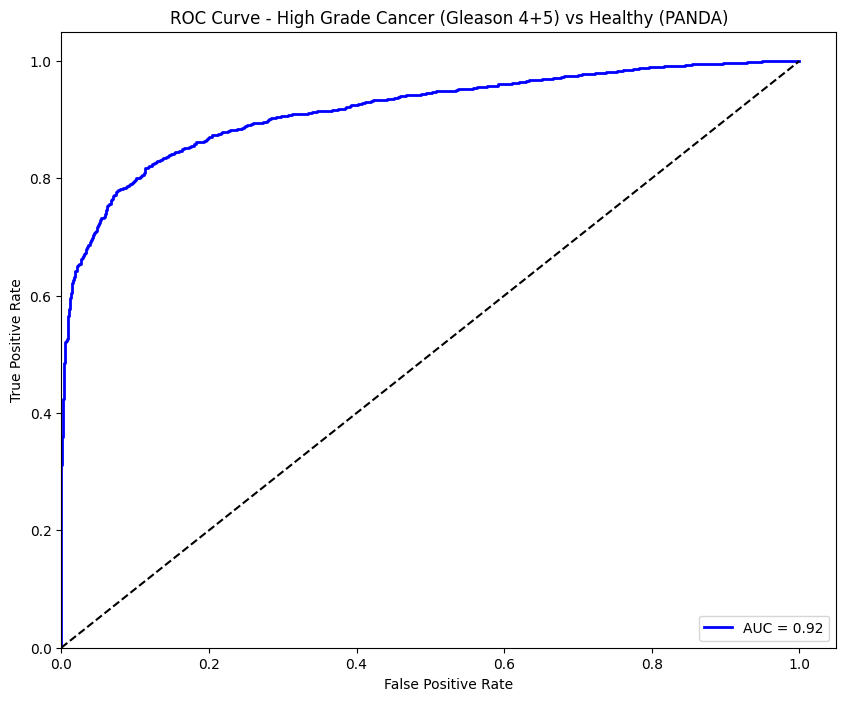

In [25]:
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, color='blue', lw=2, label='AUC = %0.2f' % auc)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - High Grade Cancer (Gleason 4+5) vs Healthy (PANDA)')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc="lower right")

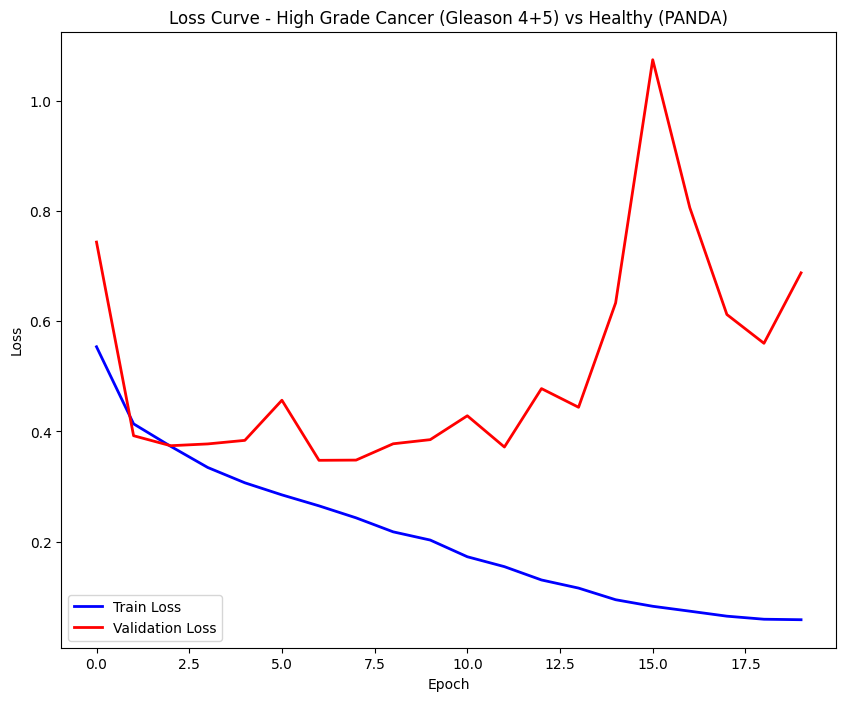

In [26]:
plt.figure(figsize=(10,8))
plt.plot(range(20), history.history['loss'], color='blue', lw=2, label = 'Train Loss')
plt.plot(range(20), history.history['val_loss'], color='red', lw=2,  label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve - High Grade Cancer (Gleason 4+5) vs Healthy (PANDA)')
plt.legend(loc="lower left")

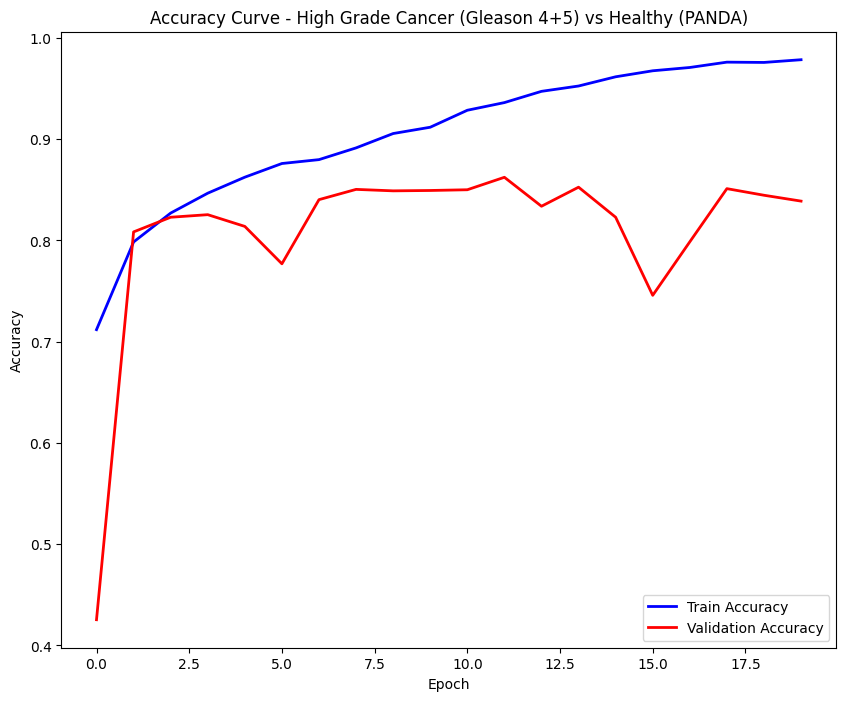

In [27]:
plt.figure(figsize=(10,8))
plt.plot(range(20), history.history['accuracy'], color='blue', lw=2, label = 'Train Accuracy')
plt.plot(range(20), history.history['val_accuracy'], color='red', lw=2,  label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve - High Grade Cancer (Gleason 4+5) vs Healthy (PANDA)')
plt.legend(loc="lower right")

In [28]:
with open("/scratch/c.c23115040/model_tr_h_vs_d", "wb") as dill_file: 
    dill.dump(model, dill_file)

In [5]:
with open("/scratch/c.c23115040/DRAQ5_input", "rb") as dill_file:
    DRAQ5_input = dill.load(dill_file)
with open("/scratch/c.c23115040/Eosin_input", "rb") as dill_file:
    Eosin_input = dill.load(dill_file)
with open("/scratch/c.c23115040/masks_segm", "rb") as dill_file:
    masks_segm = dill.load(dill_file)
with open("/scratch/c.c23115040/classif", "rb") as dill_file:
    classif = dill.load(dill_file)
with open("/scratch/c.c23115040/batch", "rb") as dill_file:
    batch = dill.load(dill_file)

In [6]:
len(DRAQ5_input)

18227

In [7]:
classif = np.array(classif)

In [8]:
batch = np.array(batch)

In [9]:
healthy = np.where(classif == 0)[0]
gleason3 = np.where(classif == 1)[0]
gleason4 = np.where(classif == 2)[0]
gleason5 = np.where(classif == 3)[0]
gleason_disease = np.concatenate((gleason4, gleason5))

In [10]:
batch_h = batch[classif == 0]
batch_3 = batch[classif == 1]
batch_4 = batch[classif == 2]
batch_5 = batch[classif == 3]
batch_d = np.concatenate((batch_4, batch_5))

In [11]:
batch

array([  0,   0,   0, ..., 241, 241, 241])

In [12]:
numb = list(range(241))
np.random.shuffle(numb)

In [13]:
list1 = numb[0:193]
list2 = numb[193:241]

In [14]:
classif2 = np.concatenate((np.full((healthy.shape[0], 1), 0), np.full((gleason3.shape[0], 1), 1)))

In [15]:
data = np.concatenate((healthy, gleason3))

In [16]:
batch2 = np.concatenate((batch_h, batch_3))

In [17]:
data = data[:, np.newaxis]

In [18]:
data = np.concatenate((data, classif2, batch2[:, np.newaxis]), axis = 1)
np.random.shuffle(data)

In [19]:
classif3 = data[:, 1]
batch3 = data[:, 2]

In [20]:
splitting = []
for i in range(batch3.shape[0]):
    splitting.append(batch3[i] in list2)
splitting = np.asarray(splitting)
    
data_train = data[splitting == 0, 0]
classif_train = classif3[splitting == 0].astype(np.uint8)
data_test = data[splitting == 1, 0]
classif_test = classif3[splitting == 1].astype(np.uint8)

DRAQ5_input = np.array(DRAQ5_input).astype(np.float16)
Eosin_input = np.array(Eosin_input).astype(np.float16)
    
DRAQ5_input_train = DRAQ5_input[data_train, :, :].astype(np.float16)
DRAQ5_input_test = DRAQ5_input[data_test, :, :].astype(np.float16)
Eosin_input_train = Eosin_input[data_train, :, :].astype(np.float16)
Eosin_input_test = Eosin_input[data_test, :, :].astype(np.float16)

input_train = np.concatenate((DRAQ5_input_train[:,:,:,np.newaxis], Eosin_input_train[:,:,:,np.newaxis]), axis = 3).astype(np.float16)
input_test = np.concatenate((DRAQ5_input_test[:,:,:,np.newaxis], Eosin_input_test[:,:,:,np.newaxis]), axis = 3).astype(np.float16)    

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath="/home/c.c23115040/checkpoint.model.keras", monitor='val_loss', mode='min', save_best_only=True)
    
model = Sequential()
model.add(layers.Conv2D(16, (3,3), padding='same', activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(), input_shape=(256, 256, 2)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Conv2D(32, (3,3), padding='same', activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform()))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Conv2D(64, (3,3), padding='same', activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform()))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Conv2D(32, (3,3), padding='same', activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform()))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Conv2D(16, (3,3), padding='same', activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform()))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(800, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform()))
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(400, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform()))
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(100, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform()))
model.add(layers.Dense(50, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform()))
model.add(layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform()))
      
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
history = model.fit(input_train, classif_train, validation_data=(input_test, classif_test), epochs=20, callbacks=[model_checkpoint_callback])

model = keras.models.load_model("/home/c.c23115040/checkpoint.model.keras")

base_conv.py (113): Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2025-07-09 21:46:23.550352: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 215s 921ms/step - accuracy: 0.5848 - loss: 0.7216 - val_accuracy: 0.4774 - val_loss: 0.8852
Epoch 2/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 203s 895ms/step - accuracy: 0.6741 - loss: 0.6055 - val_accuracy: 0.7221 - val_loss: 0.5494
Epoch 3/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 205s 906ms/step - accuracy: 0.7079 - loss: 0.5646 - val_accuracy: 0.7294 - val_loss: 0.5239
Epoch 4/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 206s 908ms/step - accuracy: 0.7219 - loss: 0.5363 - val_accuracy: 0.7589 - val_loss: 0.5004
Epoch 5/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 205s 905ms/step - accuracy: 0.7528 - loss: 0.5020 - val_accuracy: 0.7776 - val_loss: 0.4721
Epoch 6/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 208s 915ms/step - accuracy: 0.7639 - loss: 0.4806 - val_accuracy: 0.7818 - val_loss: 0.4642
Epoch 7/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 213s 941ms/step - accuracy: 0.7874 - loss: 0.4384 - val_accuracy: 0.7947 - val_loss: 0.4475
Epoch 8/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 207s 912ms/step - accuracy: 0.8030 -

In [21]:
sklearn.metrics.accuracy_score(classif_test, model.predict(input_test) > 0.5)

61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step


0.7952306894764126

In [22]:
sklearn.metrics.cohen_kappa_score(classif_test, model.predict(input_test) > 0.5)

61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step


0.5920542246564782

In [23]:
sklearn.metrics.confusion_matrix(classif_test, model.predict(input_test) > 0.5)

61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step


array([[787, 134],
       [261, 747]])

In [24]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(classif_test, model.predict(input_test))
auc = sklearn.metrics.auc(fpr, tpr)

61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step


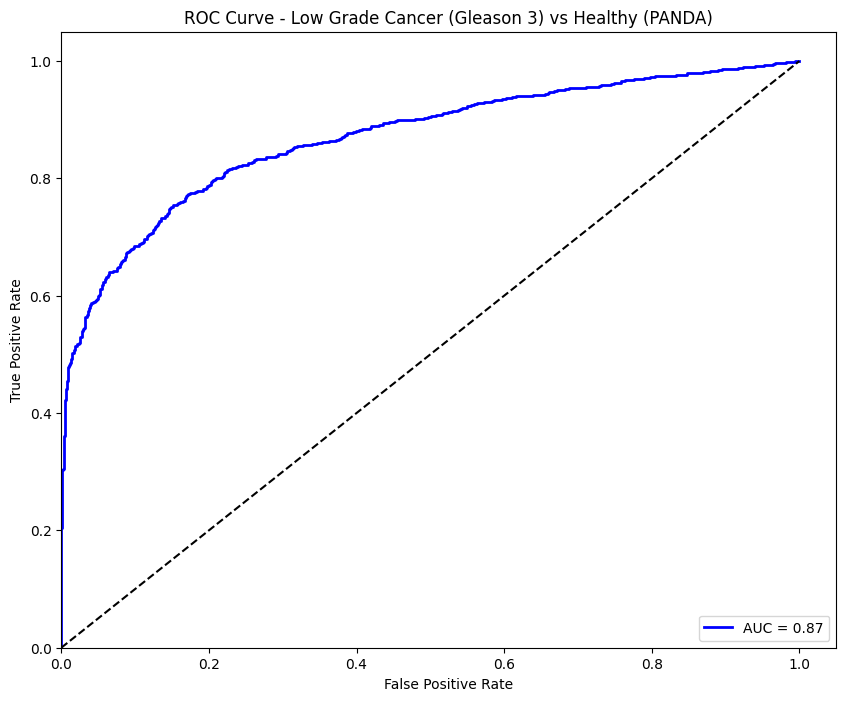

In [25]:
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, color='blue', lw=2, label='AUC = %0.2f' % auc)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Low Grade Cancer (Gleason 3) vs Healthy (PANDA)')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc="lower right")

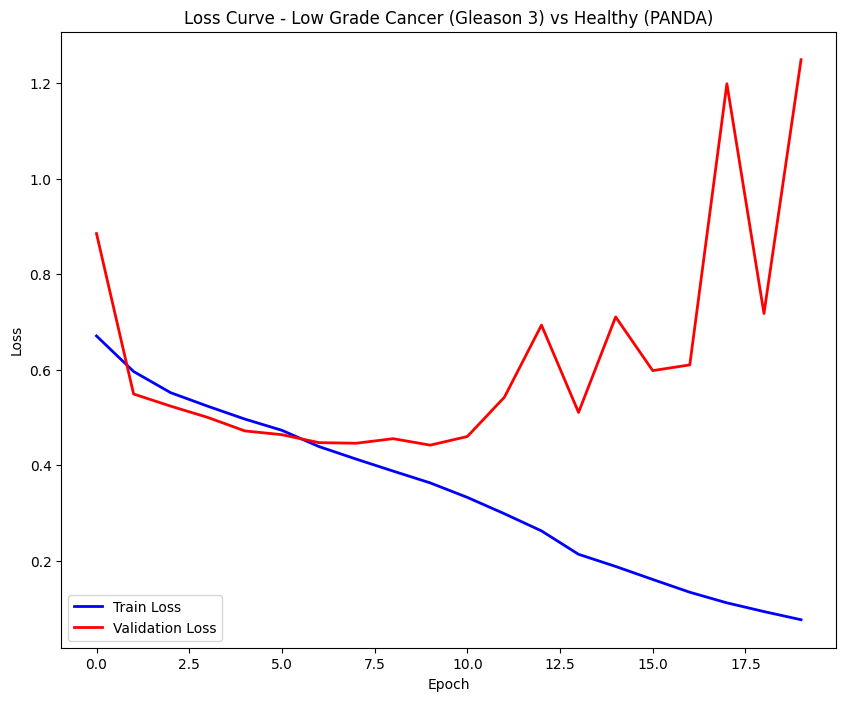

In [26]:
plt.figure(figsize=(10,8))
plt.plot(range(20), history.history['loss'], color='blue', lw=2, label = 'Train Loss')
plt.plot(range(20), history.history['val_loss'], color='red', lw=2,  label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve - Low Grade Cancer (Gleason 3) vs Healthy (PANDA)')
plt.legend(loc="lower left")

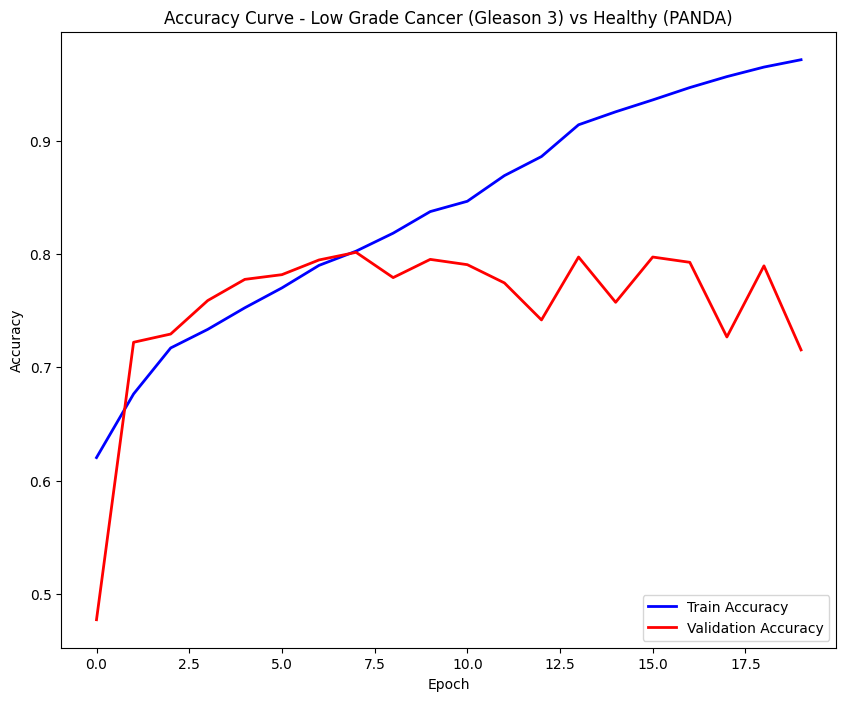

In [27]:
plt.figure(figsize=(10,8))
plt.plot(range(20), history.history['accuracy'], color='blue', lw=2, label = 'Train Accuracy')
plt.plot(range(20), history.history['val_accuracy'], color='red', lw=2,  label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve - Low Grade Cancer (Gleason 3) vs Healthy (PANDA)')
plt.legend(loc="lower right")

In [28]:
with open("/scratch/c.c23115040/model_tr_h_vs_g3", "wb") as dill_file: 
    dill.dump(model, dill_file)

In [2]:
with open("/scratch/c.c23115040/DRAQ5_input", "rb") as dill_file:
    DRAQ5_input = dill.load(dill_file)
with open("/scratch/c.c23115040/Eosin_input", "rb") as dill_file:
    Eosin_input = dill.load(dill_file)
with open("/scratch/c.c23115040/masks_segm", "rb") as dill_file:
    masks_segm = dill.load(dill_file)
with open("/scratch/c.c23115040/classif", "rb") as dill_file:
    classif = dill.load(dill_file)
with open("/scratch/c.c23115040/batch", "rb") as dill_file:
    batch = dill.load(dill_file)

In [3]:
tf.experimental.numpy.experimental_enable_numpy_behavior()

In [4]:
len(DRAQ5_input)

18227

In [5]:
for i in range(len(masks_segm)):
    masks_segm[i] = cv2.resize(masks_segm[i], (256,256), fx=0, fy=0, interpolation = cv2.INTER_NEAREST)

In [6]:
classif = np.array(classif)

In [7]:
batch = np.array(batch)

In [8]:
healthy = np.where(classif == 0)[0]
gleason3 = np.where(classif == 1)[0]
gleason4 = np.where(classif == 2)[0]
gleason5 = np.where(classif == 3)[0]
gleason_disease = np.concatenate((gleason3, gleason4, gleason5))

In [9]:
batch_h = batch[classif == 0]
batch_3 = batch[classif == 1]
batch_4 = batch[classif == 2]
batch_5 = batch[classif == 3]
batch_d = np.concatenate((batch_3, batch_4, batch_5))

In [10]:
batch

array([  0,   0,   0, ..., 241, 241, 241])

In [11]:
numb = list(range(241))
np.random.shuffle(numb)

In [12]:
list1 = numb[0:193]
list2 = numb[193:241]

In [13]:
classif2 = np.concatenate((np.full((healthy.shape[0], 1), 0), np.full((gleason_disease.shape[0], 1), 1)))

In [14]:
data = np.concatenate((healthy, gleason_disease))

In [15]:
batch2 = np.concatenate((batch_h, batch_d))

In [16]:
data = data[:, np.newaxis]

In [17]:
data = np.concatenate((data, classif2, batch2[:, np.newaxis]), axis = 1)
np.random.shuffle(data)

In [18]:
classif3 = data[:, 1]
batch3 = data[:, 2]

In [19]:
splitting = []
for i in range(batch3.shape[0]):
    splitting.append(batch3[i] in list2)
splitting = np.asarray(splitting)
    
data_train = data[splitting == 0, 0]
classif_train = classif3[splitting == 0].astype(np.uint8)
data_test = data[splitting == 1, 0]
classif_test = classif3[splitting == 1].astype(np.uint8)

DRAQ5_input = np.array(DRAQ5_input).astype(np.float16)
Eosin_input = np.array(Eosin_input).astype(np.float16)
masks_segm = np.array(masks_segm).astype(np.uint8)
masks_segm2 = masks_segm.copy()
masks_segm2[masks_segm2 == 1] = 0
masks_segm2[masks_segm2 == 2] = 1
masks_segm2[masks_segm2 > 2] = 2

DRAQ5_input_train = DRAQ5_input[data_train, :, :].astype(np.float16)
DRAQ5_input_test = DRAQ5_input[data_test, :, :].astype(np.float16)
Eosin_input_train = Eosin_input[data_train, :, :].astype(np.float16)
Eosin_input_test = Eosin_input[data_test, :, :].astype(np.float16)

masks_segm2_train = masks_segm2[data_train, :, :].astype(np.uint8)
masks_segm2_test = masks_segm2[data_test, :, :].astype(np.uint8)

#classif_train_expanded = []
#for i in range(classif_train.shape[0]):
#    classif_train_expanded.append(np.full((256, 256), classif_train[i]))
#classif_train_expanded = np.array(classif_train_expanded).astype(np.uint8)

input_train = np.concatenate((DRAQ5_input_train[:,:,:,np.newaxis], Eosin_input_train[:,:,:,np.newaxis]), axis = 3).astype(np.float16)
input_test = np.concatenate((DRAQ5_input_test[:,:,:,np.newaxis], Eosin_input_test[:,:,:,np.newaxis]), axis = 3).astype(np.float16)  

inputs = tf.keras.layers.Input(shape = (256, 256, 2))

#Contraction path
c1 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
b1 = tf.keras.layers.BatchNormalization()(c1)
r1 = tf.keras.layers.ReLU()(b1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)

c2 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
b2 = tf.keras.layers.BatchNormalization()(c2)
r2 = tf.keras.layers.ReLU()(b2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)
 
c3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3) #3 to 32 rem
b3 = tf.keras.layers.BatchNormalization()(c3)
r3 = tf.keras.layers.ReLU()(b3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(r3)
 
c4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
b4 = tf.keras.layers.BatchNormalization()(c4)
r4 = tf.keras.layers.ReLU()(b4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(r4)

c5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.2)(c5)
c5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
b5 = tf.keras.layers.BatchNormalization()(c5)
r5 = tf.keras.layers.ReLU()(b5)
p5 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(r5)

c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
b6 = tf.keras.layers.BatchNormalization()(c6)
r6 = tf.keras.layers.ReLU()(b6)
p6 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(r6)

#Expansive path 
 
u7 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c5])
u7 = tf.keras.layers.BatchNormalization()(u7)
u7 = tf.keras.layers.ReLU()(u7)

u8 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u7)
u8 = tf.keras.layers.concatenate([u8, c4])
u8 = tf.keras.layers.BatchNormalization()(u8)
u8 = tf.keras.layers.ReLU()(u8)
 
u9 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u8)
u9 = tf.keras.layers.concatenate([u9, c3], axis=3)
u9 = tf.keras.layers.BatchNormalization()(u9)
u9 = tf.keras.layers.ReLU()(u9)

u10 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u9)
u10 = tf.keras.layers.concatenate([u10, c2], axis=3)
u10 = tf.keras.layers.BatchNormalization()(u10)
u10 = tf.keras.layers.ReLU()(u10)

u11 = tf.keras.layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(u10)
u11 = tf.keras.layers.concatenate([u11, c1], axis=3)
u11 = tf.keras.layers.BatchNormalization()(u11)
u11 = tf.keras.layers.ReLU()(u11)

outputs = tf.keras.layers.Conv2D(3, (1, 1), activation='softmax')(u11)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath="/home/c.c23115040/checkpoint.model.keras", monitor='val_loss', mode='min', save_best_only=True)
history = model.fit(input_train, masks_segm2_train, validation_data=(input_test, masks_segm2_test), epochs=20, callbacks=[model_checkpoint_callback])
model = keras.models.load_model("/home/c.c23115040/checkpoint.model.keras")

2025-09-17 13:40:25.171556: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 693s 1s/step - accuracy: 0.7379 - loss: 0.6090 - val_accuracy: 0.6925 - val_loss: 0.7781
Epoch 2/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 675s 1s/step - accuracy: 0.7882 - loss: 0.4756 - val_accuracy: 0.6766 - val_loss: 0.9623
Epoch 3/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 667s 1s/step - accuracy: 0.8117 - loss: 0.4289 - val_accuracy: 0.8006 - val_loss: 0.4681
Epoch 4/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 666s 1s/step - accuracy: 0.8322 - loss: 0.3854 - val_accuracy: 0.8267 - val_loss: 0.4054
Epoch 5/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 669s 1s/step - accuracy: 0.8402 - loss: 0.3675 - val_accuracy: 0.8111 - val_loss: 0.4666
Epoch 6/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 677s 1s/step - accuracy: 0.8481 - loss: 0.3526 - val_accuracy: 0.8365 - val_loss: 0.3993
Epoch 7/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 683s 1s/step - accuracy: 0.8544 - loss: 0.3381 - val_accuracy: 0.8378 - val_loss: 0.4227
Epoch 8/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 684s 1s/step - accuracy: 0.8593 - loss: 0.3278 - val_accu

In [20]:
1 - scipy.spatial.distance.dice((masks_segm2_test == 0).ravel(), ((tf.argmax(model.predict(input_test), axis = 3) == 0).ravel()))

111/111 ━━━━━━━━━━━━━━━━━━━━ 19s 172ms/step


0.9124642550734977

In [21]:
1 - scipy.spatial.distance.dice((masks_segm2_test == 1).ravel(), ((tf.argmax(model.predict(input_test), axis = 3) == 1).ravel()))

111/111 ━━━━━━━━━━━━━━━━━━━━ 19s 167ms/step


0.650223239282208

In [22]:
1 - scipy.spatial.distance.dice((masks_segm2_test == 2).ravel(), ((tf.argmax(model.predict(input_test), axis = 3) == 2).ravel()))

111/111 ━━━━━━━━━━━━━━━━━━━━ 19s 172ms/step


0.8059026113268629

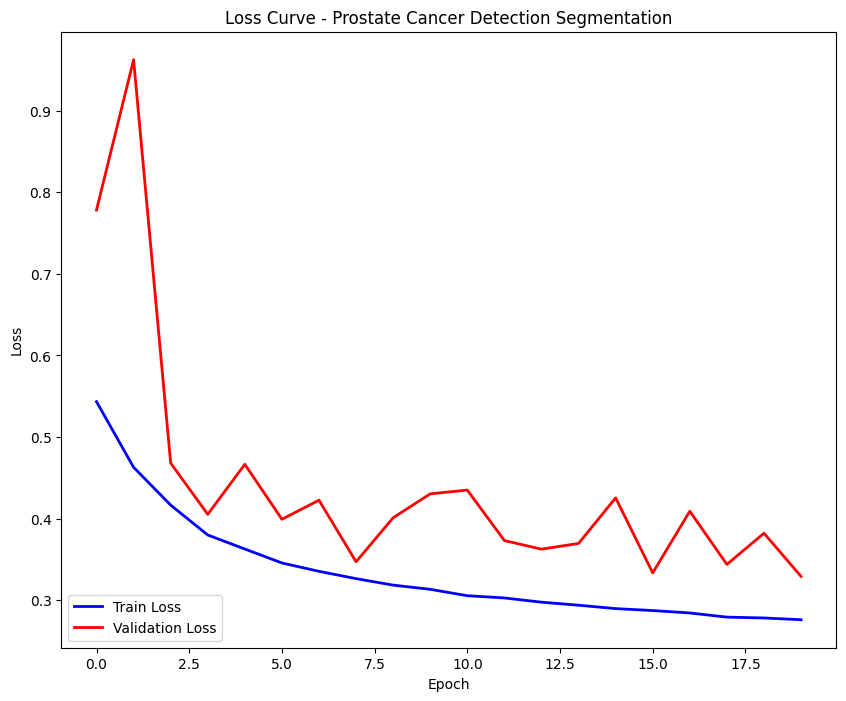

In [23]:
plt.figure(figsize=(10,8))
plt.plot(range(20), history.history['loss'], color='blue', lw=2, label = 'Train Loss')
plt.plot(range(20), history.history['val_loss'], color='red', lw=2,  label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve - Prostate Cancer Detection Segmentation')
plt.legend(loc="lower left")

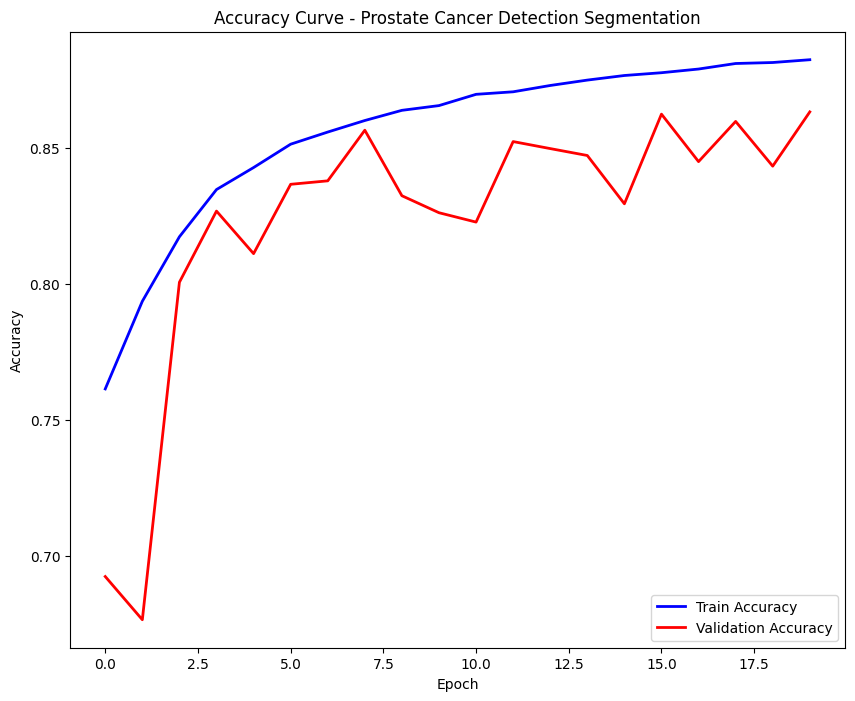

In [24]:
plt.figure(figsize=(10,8))
plt.plot(range(20), history.history['accuracy'], color='blue', lw=2, label = 'Train Accuracy')
plt.plot(range(20), history.history['val_accuracy'], color='red', lw=2,  label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve - Prostate Cancer Detection Segmentation')
plt.legend(loc="lower right")

In [25]:
with open("/scratch/c.c23115040/model_tr_canc_segm", "wb") as dill_file: 
    dill.dump(model, dill_file)

In [26]:
pred = tf.argmax(model.predict(input_test), axis = 3)

111/111 ━━━━━━━━━━━━━━━━━━━━ 18s 166ms/step


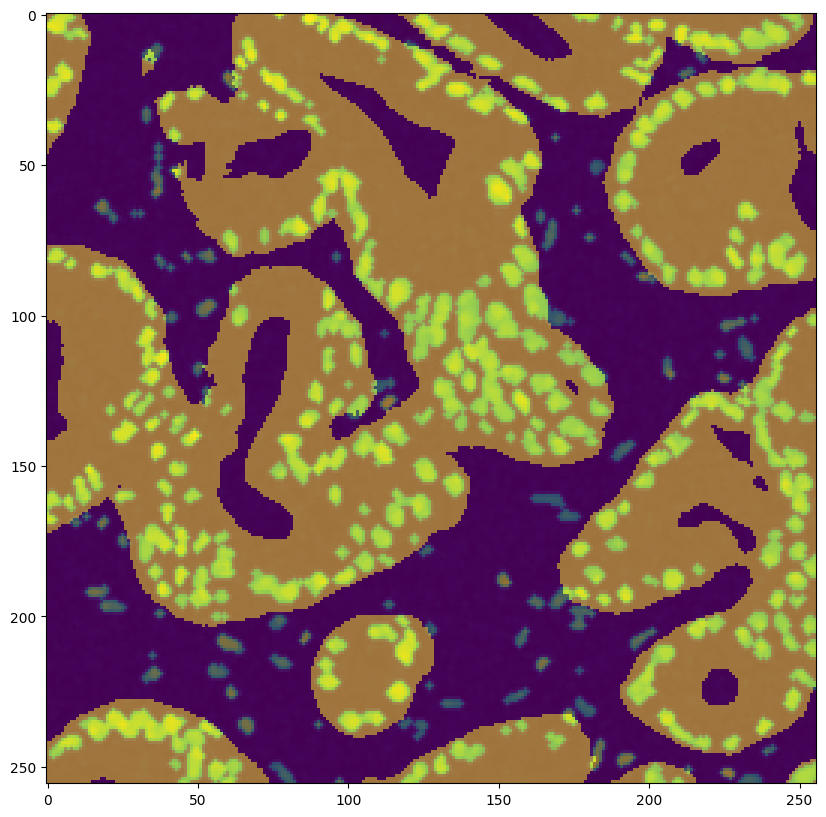

In [33]:
plt.figure(figsize = (10,10))
plt.imshow(input_test[804][:,:,0])
plt.imshow(masks_segm2_test[804], vmin = 0, vmax = 2, alpha = 0.5)

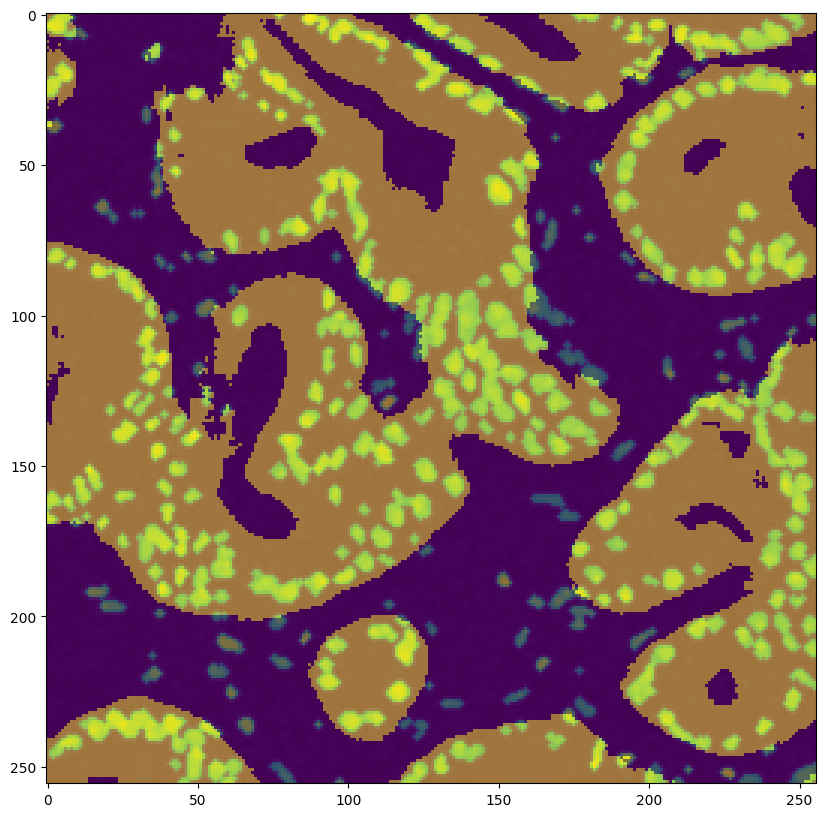

In [34]:
plt.figure(figsize = (10,10))
plt.imshow(input_test[804][:,:,0])
plt.imshow(pred[804], vmin = 0, vmax = 2, alpha = 0.5)

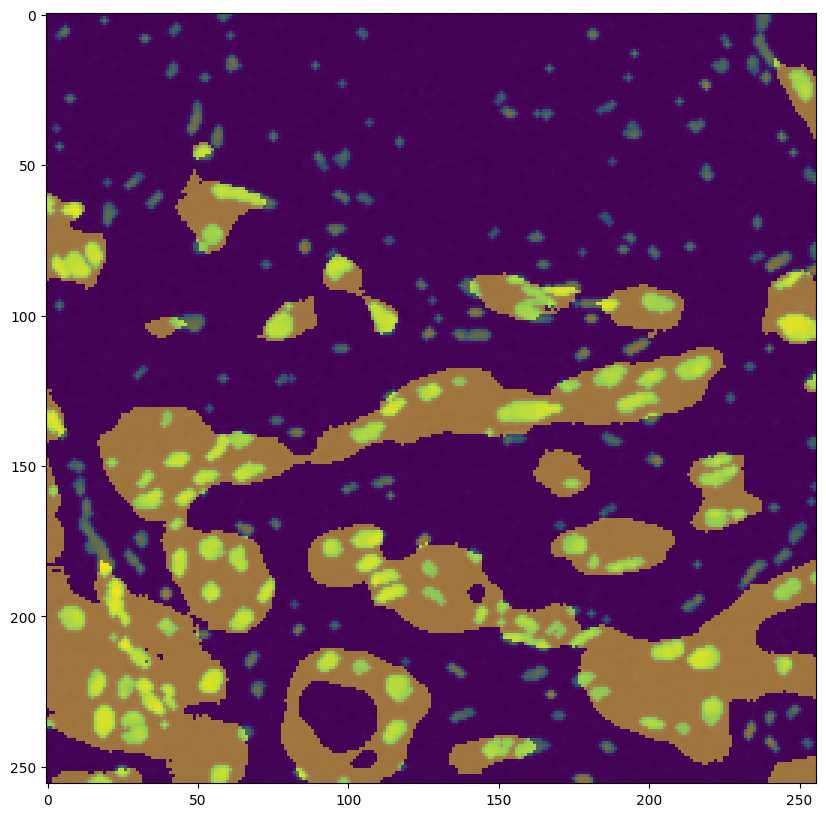

In [35]:
plt.figure(figsize = (10,10))
plt.imshow(input_test[223][:,:,0])
plt.imshow(masks_segm2_test[223], vmin = 0, vmax = 2, alpha = 0.5)

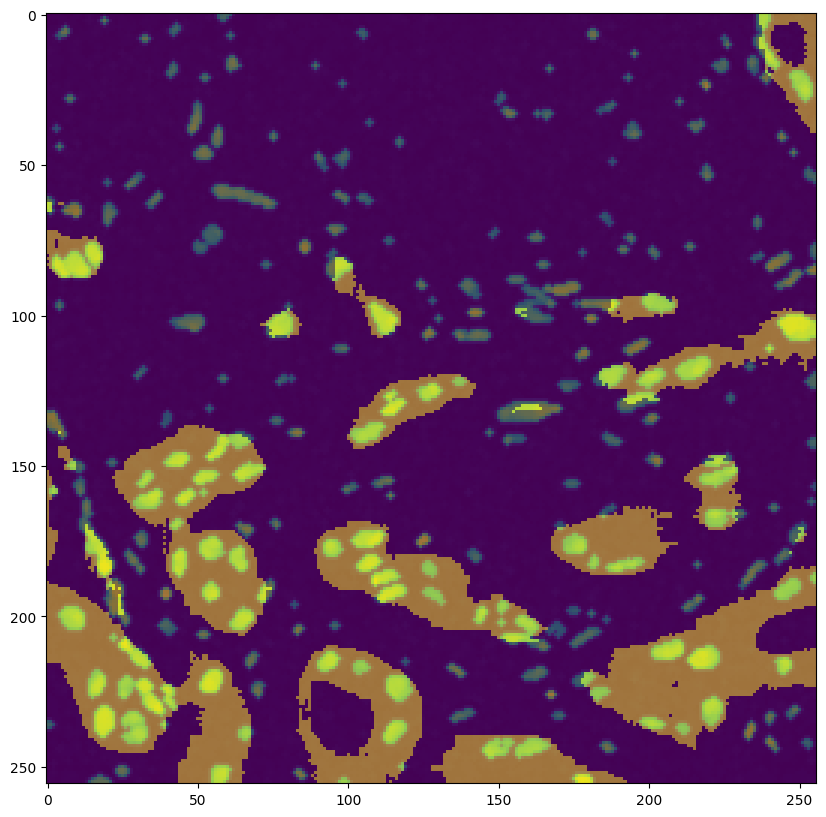

In [36]:
plt.figure(figsize = (10,10))
plt.imshow(input_test[223][:,:,0])
plt.imshow(pred[223], vmin = 0, vmax = 2, alpha = 0.5)

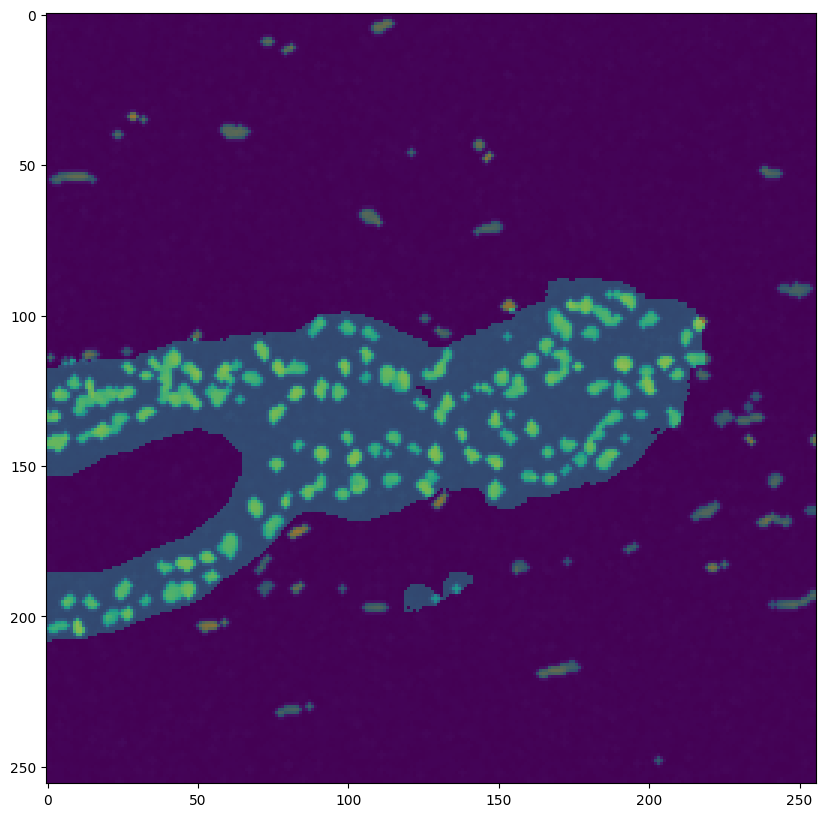

In [37]:
plt.figure(figsize = (10,10))
plt.imshow(input_test[42][:,:,0])
plt.imshow(masks_segm2_test[42], vmin = 0, vmax = 2, alpha = 0.5)

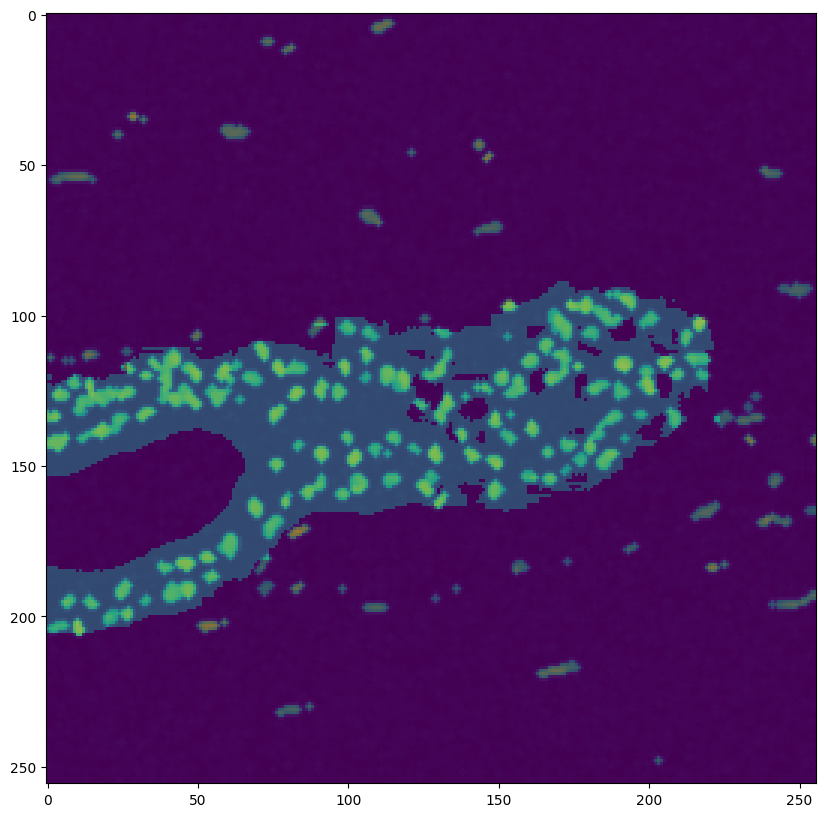

In [38]:
plt.figure(figsize = (10,10))
plt.imshow(input_test[42][:,:,0])
plt.imshow(pred[42], vmin = 0, vmax = 2, alpha = 0.5)